In [303]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

#Selection
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV, 
    cross_validate,
)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error 
from sklearn.inspection import permutation_importance

#Preprocess
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

#Modèles
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

In [305]:
df_features = pd.read_csv("df_features.csv")
df_features.head()

,BuildingType,PrimaryPropertyType,NumberofFloors,PropertyGFATotal,PropertyGFAParking,ENERGYSTARScore,GHGEmissionsIntensity,Building_Age,Emissions_per_Surface,Energy_per_Surface,GFA-1use_ratio,GFA_per_Floor,Emissions_per_floor,Energy_per_floor,Elec_ratio,steam_ratio,NGas_ratio,District
0,NonResidential,Other,12,88434,0,60.0,2.83,89,0.00,81.71,1.00,7369.50,20.83,602196.88,0.55,0.28,0.18,CENTRAL CITY
1,NonResidential,Other,10,61320,0,56.0,4.67,90,0.00,110.81,1.00,6132.00,28.64,679458.40,0.41,0.33,0.27,CENTRAL CITY
2,NonResidential,Other,11,83008,0,27.0,2.12,90,0.00,69.38,0.98,7546.18,16.01,523526.82,0.49,0.00,0.51,CENTRAL CITY
3,NonResidential,Other,8,102761,0,0.0,2.16,90,0.00,61.29,1.00,12845.12,27.69,787266.44,0.58,0.36,0.06,CENTRAL CITY
4,NonResidential,Other,9,65009,0,48.0,5.05,88,0.01,101.46,1.00,7223.22,36.47,732895.28,0.20,0.25,0.55,CENTRAL CITY


In [307]:
df_Emissions = pd.read_csv("Emissions_target.csv")
df_Emissions.head()

,TotalGHGEmissions
0,249.98
1,286.43
2,176.14
3,221.51
4,328.23


In [309]:
X = df_features

y = df_Emissions['TotalGHGEmissions']

# separation de mes données en train et test 
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=11)

In [311]:
# Définir les colonnes par type pour séparer les traitements dans les pipelines : notamment encodage.

categorical_cols = ['BuildingType', 'PrimaryPropertyType', 'District']

numerical_cols = ['NumberofFloors',
    'PropertyGFATotal', 'PropertyGFAParking',
    'GHGEmissionsIntensity', 'Building_Age','ENERGYSTARScore',
    'Emissions_per_Surface','Energy_per_Surface', 'GFA-1use_ratio', 'GFA_per_Floor',
    'Emissions_per_floor','Energy_per_floor', 'Elec_ratio', 'steam_ratio', 'NGas_ratio']

In [313]:
# appliquer les pipelines : 
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

# on définit l'ensemble des transaformations qu'on veut faire sur nos données / colonnes à travers des pipelines : 

numeric_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')), # je remplace les val manquantes si y en a par la moyenne
    ('scaler', StandardScaler()) ]) # je strandardise les chiffres sur une même échelle.
                                    #centrer les données sur 0 et/ou les ramener à un écart-type de 1

categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')), # je remplace les valeurs manquantes par la valeur la plus fréquente.
    ('onehot', OneHotEncoder(handle_unknown='ignore')) ]) # j'encode avec OneHotEncoder

In [315]:

# Avec Columns Transformer, on vient appliquer à chaque colonne, ce qu'on a défini dans les pipelines.

col_trans = ColumnTransformer([('num', numeric_pipe, numerical_cols),
                               ('cat', categorical_pipe, categorical_cols)])

In [317]:
# definition du scoring : 

scoring = {'rmse': 'neg_root_mean_squared_error',
           'mae': 'neg_mean_absolute_error',
           'r2': 'r2'}

In [319]:
# je selectionne mon modèle : 

reg = LinearRegression()

# on crée un nouveau pipeline qui va permettre de faire 2 choses à la fois : 
    # Traiter  les données selon ce qu'on a défini dans ColumnTransformer et les pipes, 
    # Puis il va entrainer le modèle selon le modèle qu'on choisit ( reg)  : 

pipeline_emissions = Pipeline([ ('preprocessing', col_trans), ('regressor', reg)])


# Je fais une validation croisée sur le jeu d'entraînement, pour tester sur plusieurs sous-parties du jeu d'entraînement.
# cela permet d'évaluer mon modèle de manière robuste, sans dépendre d'une unique division train/val.
# Cela permet aussi d'évaluer la capacité du modèle à généraliser, avant de le tester sur le jeu de test qui est mis de côté.

cv_results_emissions = cross_validate(pipeline_emissions, X_train, y_train, cv=5, scoring=scoring, return_train_score=True)

print('cv_results_emissions: ')
display(cv_results_emissions)
print('------------------------------------------')

#Résultats de la validation croisée : 
print("\n Résultats validation croisée multi target:")
print("Train R²:", np.mean(cv_results_emissions['train_r2']))
print("Test R²:", np.mean(cv_results_emissions['test_r2']))
print("Test MAE:", -np.mean(cv_results_emissions['test_mae']))
print("Test RMSE:", -np.mean(cv_results_emissions['test_rmse']))

print('\nprenons en considération que MAE et RMSE sont positive malgré que ça ressort en négatif à cause du cross validate,on ajoute (-)')

print("\nmon modèle de validation croisée explique 83.2 % de la variance dans les données d'entraînement ;c'est une bonne capacité à apprendre des données.")

print('\nLe modèle explique 70 % de la variance sur des données jamais vues  ; ça reste un bon score')

cv_results_emissions: 


{'fit_time': array([0.02436376, 0.01179886, 0.00670218, 0.01044106, 0.00337696]),
 'score_time': array([0.00403595, 0.00376511, 0.00155997, 0.00170183, 0.00127101]),
 'test_rmse': array([-22.4392971 , -24.2520975 , -24.50324253, -18.15364805,
        -51.45213234]),
 'train_rmse': array([-22.21735453, -21.63879067, -21.79052183, -23.0336987 ,
        -20.2265618 ]),
 'test_mae': array([-13.91943848, -13.87163564, -16.14310175, -12.36495209,
        -18.8807717 ]),
 'train_mae': array([-14.2349567 , -13.47747008, -13.68967194, -14.26068562,
        -12.82794714]),
 'test_r2': array([0.78817523, 0.80015756, 0.7432249 , 0.87038086, 0.3249321 ]),
 'train_r2': array([0.83211661, 0.83338817, 0.83977943, 0.81783298, 0.84037108])}

------------------------------------------

 Résultats validation croisée multi target:
Train R²: 0.8326976529214853
Test R²: 0.7053741289111193
Test MAE: 15.035979934298942
Test RMSE: 28.160083504145085

prenons en considération que MAE et RMSE sont positive malgré que ça ressort en négatif à cause du cross validate,on ajoute (-)

mon modèle de validation croisée explique 83.2 % de la variance dans les données d'entraînement ;c'est une bonne capacité à apprendre des données.

Le modèle explique 70 % de la variance sur des données jamais vues  ; ça reste un bon score


In [321]:
# Entraînement sur X_train : 

pipeline_emissions.fit(X_train, y_train)


#  Prédictions : 
y_train_pred = pipeline_emissions.predict(X_train)
y_test_pred = pipeline_emissions.predict(X_test)


#  Évaluation du modèle : 

print("\n Évaluation du modèle avec Linear Regression: ")

print("R2 train:", r2_score(y_train, y_train_pred))
print("R2 test:", r2_score(y_test, y_test_pred))
print("RMSE train:", mean_squared_error(y_train, y_train_pred, squared=False))
print("RMSE test:", mean_squared_error(y_test, y_test_pred, squared=False))
print("MAE train:", mean_absolute_error(y_train, y_train_pred))
print("MAE test:", mean_absolute_error(y_test, y_test_pred))


 Évaluation du modèle avec Linear Regression: 
R2 train: 0.8279754641025241
R2 test: 0.8386639418368186
RMSE train: 22.0984462746095
RMSE test: 21.30416618074804
MAE train: 13.71981599069149
MAE test: 14.750760063559325


In [271]:
print('\nTrain R2 = 0.827, donc le modèle explique 82.7 % de la variance dans les données d entrainement')
print('\nTest R2 = 0.838 : Il explique 83.8 % de la variance sur le jeu de test.')
print('\nMon modèle généralise bien, train R2 et test R2 sont élevés et proches prsques similaires')
print('\nLes résultats de RMSE et MAE train et test restent proches, ce qui va dans le même sens que R2, le modèle apparait bon et stable')


Train R2 = 0.827, donc le modèle explique 82.7 % de la variance dans les données d entrainement

Test R2 = 0.838 : Il explique 83.8 % de la variance sur le jeu de test.

Mon modèle généralise bien, train R2 et test R2 sont élevés et proches prsques similaires

Les résultats de RMSE et MAE train et test restent proches, ce qui va dans le même sens que R2, le modèle apparait bon et stable


In [325]:
# on fait la même chose pour DummyRegressor : 

dummy_reg = DummyRegressor(strategy='mean')

# creation de pipeline : 
pipeline_emissions_dummy = Pipeline([('preprocessing', col_trans), ('regressor', dummy_reg)])


# validation croisée : 
cv_results_emissions_dummy = cross_validate(pipeline_emissions_dummy, X_train, y_train, cv=5, scoring=scoring, return_train_score=True)


print("\nDummy Regressor - Emissions CROSS VALIDATION : ")
print("Test R²:", np.mean(cv_results_emissions_dummy['test_r2']))
print("Test RMSE:", -np.mean(cv_results_emissions_dummy['test_rmse']))
print("Test MAE:", -np.mean(cv_results_emissions_dummy['test_mae']))


# entrainement : 

pipeline_emissions_dummy.fit(X_train, y_train)


#  Prédictions : 
y_train_pred_dummy = pipeline_emissions_dummy.predict(X_train)
y_test_pred_dummy = pipeline_emissions_dummy.predict(X_test)



#  Évaluation - Emissions
print("\n Évaluation finale - Emissions avec Dummy: ")
print("R2 train:", r2_score(y_train, y_train_pred_dummy))
print("R2 test:", r2_score(y_test, y_test_pred_dummy))
print("RMSE train:", mean_squared_error(y_train, y_train_pred_dummy, squared=False))
print("RMSE test:", mean_squared_error(y_test, y_test_pred_dummy, squared=False))
print("MAE train:", mean_absolute_error(y_train, y_train_pred_dummy))
print("MAE test:", mean_absolute_error(y_test, y_test_pred_dummy))


Dummy Regressor - Emissions CROSS VALIDATION : 
Test R²: -0.008329439717340126
Test RMSE: 53.09479932158067
Test MAE: 38.338710474196475

 Évaluation finale - Emissions avec Dummy: 
R2 train: 0.0
R2 test: -3.328388038603691e-05
RMSE train: 53.28028538930829
RMSE test: 53.04030925234762
MAE train: 38.27697799909462
MAE test: 39.91777497295349


In [327]:
print('Dummy is Dumb indeed lol ! ')
print('Dummy n’apprend rien de la cross validation entrainement R2 = 0') 
print('Le modèle ne comprend pas la relation entre les variables explicatives et les targets R2 nulles')

Dummy is Dumb indeed lol ! 
Dummy n’apprend rien de la cross validation entrainement R2 = 0
Le modèle ne comprend pas la relation entre les variables explicatives et les targets R2 nulles


In [329]:
# on fait la même chose pour RandomForestRegressor : 

rf = RandomForestRegressor(n_estimators=10, random_state=42)


# creation de pipeline :

pipeline_emissions_rf = Pipeline([('preprocessing', col_trans), ('regressor', rf)])


# validation croisée : 
cv_results_emissions_rf= cross_validate(pipeline_emissions_rf, X_train, y_train, cv=5, scoring=scoring, return_train_score=True)


print("\n RandomForest Regressor - Emissions CROSS VALIDATION : ")
print("Test R²:", np.mean(cv_results_emissions_rf['test_r2']))
print("Test RMSE:", -np.mean(cv_results_emissions_rf['test_rmse']))
print("Test MAE:", -np.mean(cv_results_emissions_rf['test_mae']))


# entrainement : 

pipeline_emissions_rf.fit(X_train, y_train)


#  Prédictions : 
y_train_pred_rf = pipeline_emissions_rf.predict(X_train)
y_test_pred_rf = pipeline_emissions_rf.predict(X_test)



#  Évaluation - Emissonq
print("\n Évaluation finale - Emissions avec Random Forest: ")
print("R2 train:", r2_score(y_train, y_train_pred_rf))
print("R2 test:", r2_score(y_test, y_test_pred_rf))
print("RMSE train:", mean_squared_error(y_train, y_train_pred_rf, squared=False))
print("RMSE test:", mean_squared_error(y_test, y_test_pred_rf, squared=False))
print("MAE train:", mean_absolute_error(y_train, y_train_pred_rf))
print("MAE test:", mean_absolute_error(y_test, y_test_pred_rf))


 RandomForest Regressor - Emissions CROSS VALIDATION : 
Test R²: 0.9420877922549262
Test RMSE: 12.515588043064103
Test MAE: 5.1824457446808525

 Évaluation finale - Emissions avec Random Forest: 
R2 train: 0.9889661483550972
R2 test: 0.9722268063401178
RMSE train: 5.596675316079807
RMSE test: 8.839174983071437
MAE train: 2.1171234042553193
MAE test: 4.091694915254236


**R² train = 0.988 : le modèle explique 98.8 % de la variance sur l'entraînement.**

**R² test = 0.972 : Un très bon score, donc le modèle est très bon et arrive à prédire à hauteur de  97% .**

**RMSE et MAE : les erreurs sur le test sont plus grandes que sur le train, cela reflère un léger surapprentissage.**

**Mais les résultats de Random Forest sont meilleurs que ceux de Linear Regression et évidemment du Dummy Regressor.**

**Rappel : résultats de l'évaluation du modèle avec Linear Regression :**  
**R² train : 0.827**  
**R² test : 0.838**  
**RMSE train : 22**  
**RMSE test : 21**  
**MAE train : 13**  
**MAE test : 14**

In [279]:
from sklearn.model_selection import GridSearchCV
# Je fais GrisSearch pour optimiser les paramètres du modèle Random Forest
# Je définis la grille d'hyperparamètres : 

param_grid = {'regressor__n_estimators': [50, 100],
              'regressor__max_depth': [5,10, 20, None],
              'regressor__max_features': [10,'sqrt', 'log2', None] }

# j'applique GridSearch avec validation croisée : 

grid_search = GridSearchCV( pipeline_emissions_rf, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1 )
grid_search

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['NumberofFloors',
                                                                          'PropertyGFATotal',
                                                                          'PropertyGFAParking',
                                                                          'GHGEmissionsIntensity',
                                                                          'Building_Age',
                                                                          'ENERGYSTARScore',
                                                                          'Emissions_per_Surface',
                                                                          'Energy_per_Surface',
                                                                          'GFA-1use_ratio'...
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['BuildingType',
                                                                          'PrimaryPropertyType',
                                                                          'District'])])),
                                       ('regressor',
                                        RandomForestRegressor(n_estimators=10,
                                                              random_state=42))]),
             n_jobs=-1,
             param_grid={'regressor__max_depth': [5, 10, 20, None],
                         'regressor__max_features': [10, 'sqrt', 'log2', None],
                         'regressor__n_estimators': [50, 100]},
             scoring='r2', verbose=1)

In [281]:
# je fais le fit sur train pour obtenir les meilleurs hyperparamètres : 

grid_search.fit(X_train, y_train)

# j'obtiens les meilleurs hyperparamètres pour mon modèle : 

print("\n Voici les meilleurs hyperparamètres :")

print(grid_search.best_params_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits

 Voici les meilleurs hyperparamètres :
{'regressor__max_depth': 10, 'regressor__max_features': None, 'regressor__n_estimators': 100}


In [283]:
print("Voici le meilleur score R² pour la validation croisée GridSearch :", grid_search.best_score_)

Voici le meilleur score R² pour la validation croisée GridSearch : 0.9544475909691206


In [285]:
print(grid_search.best_estimator_)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['NumberofFloors',
                                                   'PropertyGFATotal',
                                                   'PropertyGFAParking',
                                                   'GHGEmissionsIntensity',
                                                   'Building_Age',
                                                   'ENERGYSTARScore',
                                                   'Emissions_per_Surface',
                                                   'Energy_per_Surface',
      

In [287]:
# on va appliquer (grid_search.best_estimator_) pour générer nos prédictions : 

y_train_pred_gridsearch = grid_search.best_estimator_.predict(X_train)
y_test_pred_gridsearch = grid_search.best_estimator_.predict(X_test)

In [331]:
#  on obtient nos résultats de scoring avec Grid Search : 

print("\n Évaluation finale - avec Grid Search: ")
print("R2 train:", r2_score(y_train, y_train_pred_gridsearch ))
print("R2 test:", r2_score(y_test, y_test_pred_gridsearch))
print("RMSE train:", mean_squared_error(y_train, y_train_pred_gridsearch , squared=False))
print("RMSE test:", mean_squared_error(y_test, y_test_pred_gridsearch, squared=False))
print("MAE train:", mean_absolute_error(y_train, y_train_pred_gridsearch ))
print("MAE test:", mean_absolute_error(y_test, y_test_pred_gridsearch))


 Évaluation finale - avec Grid Search: 
R2 train: 0.9942806794063872
R2 test: 0.9804773383923501
RMSE train: 4.029384978953997
RMSE test: 7.410855298354202
MAE train: 1.4890798290210898
MAE test: 3.200234995081488


In [291]:
print("\n Évaluation finale - avec Grid Search: ")
print("R2 train:", r2_score(y_train, y_train_pred_gridsearch ))
print("R2 test:", r2_score(y_test, y_test_pred_gridsearch))
print("RMSE train:", mean_squared_error(y_train, y_train_pred_gridsearch , squared=False))
print("RMSE test:", mean_squared_error(y_test, y_test_pred_gridsearch, squared=False))
print("MAE train:", mean_absolute_error(y_train, y_train_pred_gridsearch ))
print("MAE test:", mean_absolute_error(y_test, y_test_pred_gridsearch))

print("\n Évaluation finale -  avec Random Forest: ")
print("R2 train:", r2_score(y_train, y_train_pred_rf))
print("R2 test:", r2_score(y_test, y_test_pred_rf))
print("RMSE train:", mean_squared_error(y_train, y_train_pred_rf, squared=False))
print("RMSE test:", mean_squared_error(y_test, y_test_pred_rf, squared=False))
print("MAE train:", mean_absolute_error(y_train, y_train_pred_rf))
print("MAE test:", mean_absolute_error(y_test, y_test_pred_rf))


 Évaluation finale - avec Grid Search: 
R2 train: 0.9942806794063872
R2 test: 0.9804773383923501
RMSE train: 4.029384978953997
RMSE test: 7.410855298354202
MAE train: 1.4890798290210898
MAE test: 3.200234995081488

 Évaluation finale -  avec Random Forest: 
R2 train: 0.9889661483550972
R2 test: 0.9722268063401178
RMSE train: 5.596675316079807
RMSE test: 8.839174983071437
MAE train: 2.1171234042553193
MAE test: 4.091694915254236


Je constate que tous les scores de R2 sont meilleurs avec Gris Search que avec Random Forest. 
Mais comme le Random Forest avait déjà des bons résultats avant d'être optimisé, l'impact de l'optimisation reste faible par rapport au résultats précédents. On peut pas faire beaucoup mieux ! 

In [294]:
# Récupération des colonnes après preprocessing
feature_names = grid_search.best_estimator_.named_steps['preprocessing'].get_feature_names_out()

# Importance des features
importances = grid_search.best_estimator_.named_steps['regressor'].feature_importances_

# Affichage trié
feature_importance = pd.DataFrame({'Feature': feature_names,'Importance': importances})
feature_importance.head()

,Feature,Importance
0,num__NumberofFloors,0.081257
1,num__PropertyGFATotal,0.194705
2,num__PropertyGFAParking,0.000891
3,num__GHGEmissionsIntensity,0.413167
4,num__Building_Age,0.004390


In [296]:
# voici le classement des features les plus importantes pour notre modèle : 
feature_importance.sort_values(by='Importance', ascending=False)

,Feature,Importance
3,num__GHGEmissionsIntensity,0.413167
10,num__Emissions_per_floor,0.265706
1,num__PropertyGFATotal,0.194705
0,num__NumberofFloors,0.081257
12,num__Elec_ratio,0.009653
7,num__Energy_per_Surface,0.008246
4,num__Building_Age,0.004390
14,num__NGas_ratio,0.004362
9,num__GFA_per_Floor,0.003339
8,num__GFA-1use_ratio,0.003053


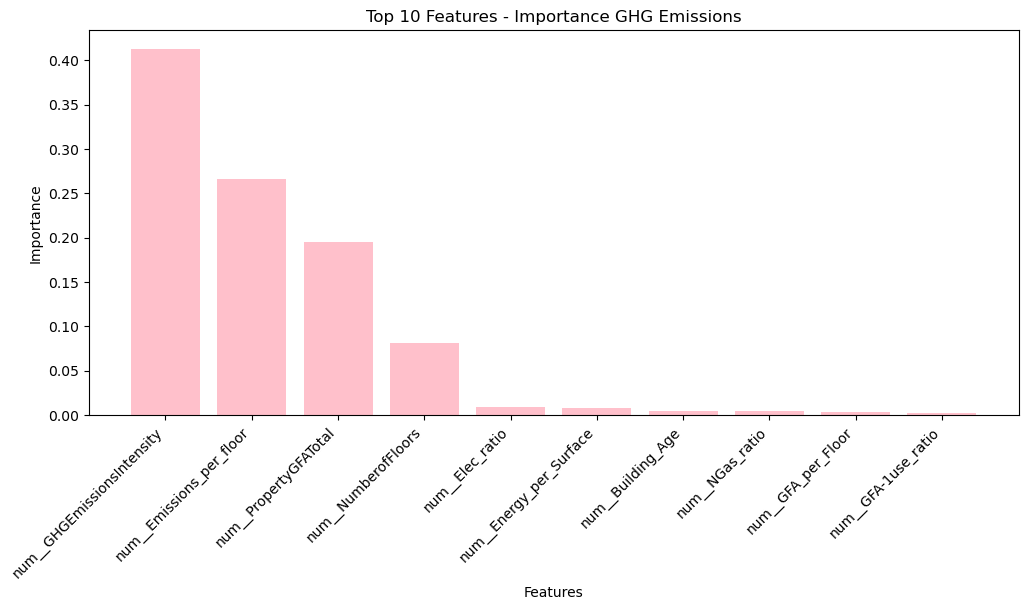

In [333]:
top_features = feature_importance.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(12, 5))
plt.bar(top_features['Feature'], top_features['Importance'], color='pink')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Top 10 Features - Importance GHG Emissions')
plt.xticks(rotation=45, ha='right')  
plt.show()

In [300]:
# on fait la même chose pour SVR : 

svr = SVR(kernel='rbf', C=1.0, epsilon=0.1) 

# creation de pipeline :

pipeline_emissions_svr = Pipeline([('preprocessing', col_trans), ('regressor', svr)])


# validation croisée : 
cv_results_emissions_svr= cross_validate(pipeline_emissions_svr, X_train, y_train, cv=5, scoring=scoring, return_train_score=True)


print("\n SVR - Emissions CROSS VALIDATION : ")
print("Test R²:", np.mean(cv_results_emissions_svr['test_r2']))
print("Test RMSE:", -np.mean(cv_results_emissions_svr['test_rmse']))
print("Test MAE:", -np.mean(cv_results_emissions_svr['test_mae']))


# entrainement : 

pipeline_emissions_svr.fit(X_train, y_train)


#  Prédictions : 
y_train_pred_svr = pipeline_emissions_svr.predict(X_train)
y_test_pred_svr = pipeline_emissions_svr.predict(X_test)

#  Évaluation - Emissions
print("\n Évaluation finale - Emissions avec SVR : ")
print("R2 train:", r2_score(y_train, y_train_pred_svr))
print("R2 test:", r2_score(y_test, y_test_pred_svr))
print("RMSE train:", mean_squared_error(y_train, y_train_pred_svr, squared=False))
print("RMSE test:", mean_squared_error(y_test, y_test_pred_svr, squared=False))
print("MAE train:", mean_absolute_error(y_train, y_train_pred_svr))
print("MAE test:", mean_absolute_error(y_test, y_test_pred_svr))


 SVR - EnergyUse CROSS VALIDATION : 
Test R²: 0.3594925264091899
Test RMSE: 42.42711059974651
Test MAE: 21.4478867232237

 Évaluation finale - EnergyUse avec SVR : 
R2 train: 0.40879986139537283
R2 test: 0.4254302153007383
RMSE train: 40.96696643187882
RMSE test: 40.20408773365266
MAE train: 20.071833120088343
MAE test: 21.104552230422378


Le modèle SVR n'est pas du tout performant dans ce cas. il n'arrive pas à bien modéliser les relations entre les variables. 
les scores sont faibles. Il n'est peut être pas adapté à ce jeu de données ou nécessite des étapes de traitement supplémentaires...